<a href="https://colab.research.google.com/github/viniciusriosfuck/python-financas/blob/main/Python_para_finan%C3%A7as_s%C3%A9ries_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries temporais em bases financeiras - ARIMA

Não adequado para ações, pois não tem padrões temporais cíclicos bem definidos, sendo influenciado por muitos fatores externos.

## Instalação e importação das bibliotecas

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 7.6MB/s 
     |████████████████████████████████| 9.5MB 17.0MB/s 
     |████████████████████████████████| 2.1MB 42.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [3]:
import pandas as pd
from pandas_datareader import data

acoes = ['GOLL4.SA', 'CVCB3.SA', 'WEGE3.SA', 'MGLU3.SA', 'TOTS3.SA', 'BOVA11.SA']
acoes_df = pd.DataFrame()
for acao in acoes:
  acoes_df[acao] = data.DataReader(acao, data_source='yahoo', start='2015-01-01')['Close']

acoes_df = acoes_df.rename(columns={'GOLL4.SA': 'GOL', 'CVCB3.SA': 'CVC', 'WEGE3.SA': 'WEGE',
                                    'MGLU3.SA': 'MGLU', 'TOTS3.SA': 'TOTS', 'BOVA11.SA': 'BOVA'})

acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')

days_bolsa = 246

In [101]:
acoes_ex = ['ABEV3.SA', 'ODPV3.SA', 'VIVT3.SA', 'PETR3.SA', 'BBAS3.SA', 'BOVA11.SA']
acoes_ex_df = pd.DataFrame()
for acao in acoes_ex:
  acoes_ex_df[acao] = data.DataReader(acao, data_source='yahoo', start='2015-01-01')['Close']
acoes_ex_df.dropna(inplace=True)
acoes_ex_df = acoes_ex_df.rename(columns={
    'ABEV3.SA': 'AMBEV', 'ODPV3.SA': 'ODONTOPREV', 'VIVT3.SA': 'VIVO',
    'PETR3.SA': 'PETROBRAS', 'BBAS3.SA': 'BBRASIL', 'BOVA11.SA': 'BOVA'})
acoes_ex_df.to_csv('acoes_ex.csv')

## Carregamento da base de dados

In [14]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('acoes.csv', parse_dates=['Date'], index_col='Date',
                      date_parser = dateparse, usecols = ['Date', 'BOVA'])

dataset2 = pd.read_csv('acoes.csv')
dataset2['Date'] = pd.to_datetime(dataset2['Date'])
dataset2.set_index('Date', inplace=True)
dataset2 = dataset2[['BOVA']]
assert dataset.equals(dataset2)
dataset

,BOVA
Date,
2015-01-02,47.259998
2015-01-05,46.320000
2015-01-06,46.580002
2015-01-07,48.150002
2015-01-08,48.509998
...,...
2021-01-22,113.180000
2021-01-26,112.970001
2021-01-27,112.970001


In [15]:
time_series = dataset['BOVA']
time_series

Date
2015-01-02     47.259998
2015-01-05     46.320000
2015-01-06     46.580002
2015-01-07     48.150002
2015-01-08     48.509998
                 ...    
2021-01-22    113.180000
2021-01-26    112.970001
2021-01-27    112.970001
2021-01-28    113.910004
2021-01-29    110.559998
Name: BOVA, Length: 1503, dtype: float64

## Exploração da série temporal

In [16]:
time_series[1]

46.31999969482422

In [17]:
time_series['2015-01-08']

48.5099983215332

In [18]:
time_series['2015-01-01':'2015-01-10']

Date
2015-01-02    47.259998
2015-01-05    46.320000
2015-01-06    46.580002
2015-01-07    48.150002
2015-01-08    48.509998
2015-01-09    47.529999
Name: BOVA, dtype: float64

In [19]:
time_series[:'2015-07-31']

Date
2015-01-02    47.259998
2015-01-05    46.320000
2015-01-06    46.580002
2015-01-07    48.150002
2015-01-08    48.509998
                ...    
2015-07-27    47.349998
2015-07-28    48.180000
2015-07-29    48.740002
2015-07-30    48.430000
2015-07-31    49.369999
Name: BOVA, Length: 144, dtype: float64

In [20]:
time_series['2015']

Date
2015-01-02    47.259998
2015-01-05    46.320000
2015-01-06    46.580002
2015-01-07    48.150002
2015-01-08    48.509998
                ...    
2015-12-22    42.230000
2015-12-23    42.750000
2015-12-28    42.500000
2015-12-29    42.419998
2015-12-30    42.130001
Name: BOVA, Length: 246, dtype: float64

In [32]:
time_series.index.max().strftime("%d/%m/%Y")

'29/01/2021'

In [22]:
time_series.index.min()

Timestamp('2015-01-02 00:00:00')

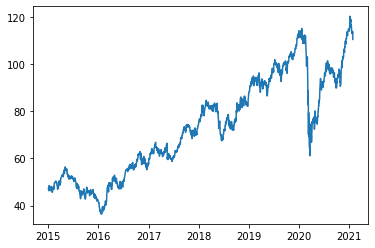

In [23]:
plt.plot(time_series);

In [24]:
figura = px.line(title='Histórico do preço das ações')
figura.add_scatter(x=time_series.index, y=time_series)

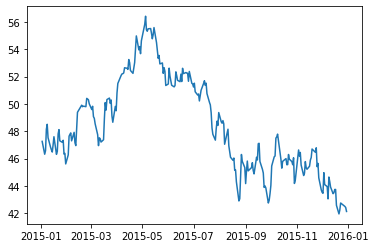

In [28]:
plt.plot(time_series['2015']);

## Decomposição da série temporal

In [36]:
type(time_series)

pandas.core.series.Series

In [37]:
len(time_series) / 2

751.5

In [38]:
decomposicao = seasonal_decompose(
    time_series,
    # period=len(time_series) // 2
    period=days_bolsa
    )

In [39]:
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

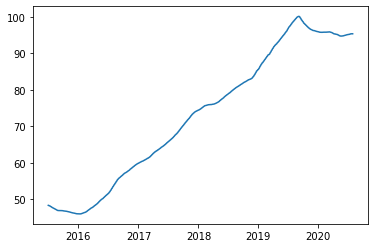

In [40]:
plt.plot(tendencia);

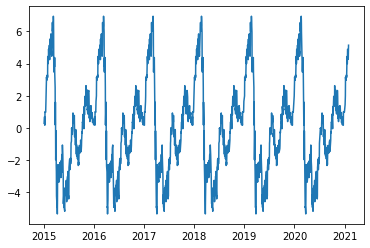

In [41]:
plt.plot(sazonal);

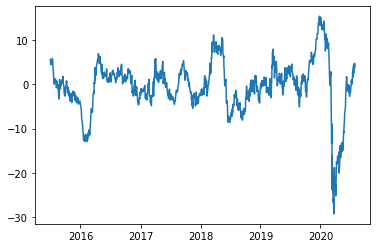

In [42]:
plt.plot(aleatorio);

## Previsões com ARIMA

In [43]:
%%time
modelo = auto_arima(time_series, suppress_warnings=True, error_action='ignore')

In [44]:
# Parâmetros P, Q e D
modelo.order

(4, 1, 4)

In [46]:
previsoes = modelo.predict(n_periods=90)
previsoes

array([110.59759723, 110.44240703, 109.88023434, 110.13462193,
       109.34610763, 109.70510977, 109.10732897, 109.28413522,
       109.11358548, 109.00762989, 109.23605792, 108.95138938,
       109.35889903, 109.09756976, 109.43067227, 109.35103256,
       109.46239346, 109.59194491, 109.49093153, 109.73259743,
       109.53988496, 109.7489679 , 109.6021749 , 109.67587924,
       109.64920314, 109.57558513, 109.65423157, 109.5012717 ,
       109.61185445, 109.47485475, 109.54166909, 109.48658942,
       109.47617127, 109.51087179, 109.44236676, 109.52553414,
       109.44865123, 109.52334028, 109.48350371, 109.51153899,
       109.52474849, 109.50298336, 109.55253289, 109.50615911,
       109.55845405, 109.52026818, 109.54685279, 109.5371343 ,
       109.52931388, 109.54733123, 109.51680991, 109.54603919,
       109.51418559, 109.53523129, 109.51934016, 109.52159832,
       109.52637818, 109.51217813, 109.53001823, 109.51057037,
       109.52851043, 109.5157206 , 109.52379696, 109.52

## Gráfico das previsões

In [47]:
len(time_series)

1503

In [48]:
treinamento = time_series[:1081]
treinamento.shape

(1081,)

In [49]:
treinamento.index.min(), treinamento.index.max()

(Timestamp('2015-01-02 00:00:00'), Timestamp('2019-05-10 00:00:00'))

In [50]:
teste = time_series[1081:]
teste.shape

(422,)

In [51]:
teste.index.min(), teste.index.max()

(Timestamp('2019-05-13 00:00:00'), Timestamp('2021-01-29 00:00:00'))

In [52]:
%%time
modelo2 = auto_arima(treinamento, suppress_warnings=True, error_action='ignore')

CPU times: user 4.87 s, sys: 3.42 s, total: 8.29 s
Wall time: 4.28 s


In [53]:
teste.index

DatetimeIndex(['2019-05-13', '2019-05-14', '2019-05-15', '2019-05-16',
               '2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24',
               ...
               '2021-01-15', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Date', length=422, freq=None)

In [57]:
previsoes = pd.DataFrame(
    modelo2.predict(n_periods=len(teste)),
    index=teste.index,
    columns=['previsoes']
    )
previsoes

,previsoes
Date,
2019-05-13,90.900022
2019-05-14,90.977381
2019-05-15,91.040707
2019-05-16,91.095342
2019-05-17,91.144594
...,...
2021-01-22,107.883795
2021-01-26,107.924291
2021-01-27,107.964787


In [58]:
teste

Date
2019-05-13     88.309998
2019-05-14     88.760002
2019-05-15     87.870003
2019-05-16     86.559998
2019-05-17     86.739998
                 ...    
2021-01-22    113.180000
2021-01-26    112.970001
2021-01-27    112.970001
2021-01-28    113.910004
2021-01-29    110.559998
Name: BOVA, Length: 422, dtype: float64

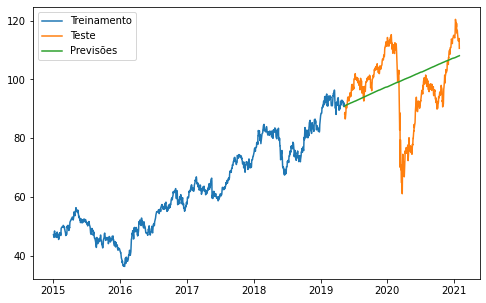

In [59]:
plt.figure(figsize=(8,5))
plt.plot(treinamento, label='Treinamento')
plt.plot(teste, label='Teste')
plt.plot(previsoes, label='Previsões')
plt.legend();

## Avaliação do ARIMA

In [69]:
from sklearn.metrics import mean_absolute_error
assert np.allclose(mean_absolute_error(teste, previsoes),
        sum(abs(teste - previsoes['previsoes']) / len(teste)))
mean_absolute_error(teste, previsoes)

9.665953125122337

# Séries temporais em bases financeiras - Facebook Prophet

## Instalação e importação das bibliotecas

In [70]:
!pip install fbprophet

In [71]:
from fbprophet import Prophet
import pandas as pd

## Carregamento da base de dados

In [72]:
dataset = pd.read_csv('acoes.csv', usecols=['Date', 'BOVA'])
dataset

,Date,BOVA
0,2015-01-02,47.259998
1,2015-01-05,46.320000
2,2015-01-06,46.580002
3,2015-01-07,48.150002
4,2015-01-08,48.509998
...,...,...
1498,2021-01-22,113.180000
1499,2021-01-26,112.970001
1500,2021-01-27,112.970001
1501,2021-01-28,113.910004


In [73]:
dataset = dataset[['Date', 'BOVA']].rename(columns = {'Date': 'ds', 'BOVA': 'y'})
dataset

,ds,y
0,2015-01-02,47.259998
1,2015-01-05,46.320000
2,2015-01-06,46.580002
3,2015-01-07,48.150002
4,2015-01-08,48.509998
...,...,...
1498,2021-01-22,113.180000
1499,2021-01-26,112.970001
1500,2021-01-27,112.970001
1501,2021-01-28,113.910004


## Construção do modelo e previsões

In [74]:
%%time
modelo = Prophet()
modelo.fit(dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.36 s, sys: 129 ms, total: 2.49 s
Wall time: 3.15 s


In [75]:
%%time
futuro = modelo.make_future_dataframe(periods=90)
previsoes = modelo.predict(futuro)

CPU times: user 4.38 s, sys: 3.38 s, total: 7.76 s
Wall time: 4.03 s


In [76]:
previsoes.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,48.443997,44.596055,60.487308,48.443997,48.443997,4.212213,4.212213,4.212213,0.279474,0.279474,0.279474,3.932740,3.932740,3.932740,0.0,0.0,0.0,52.656210
1,2015-01-05,48.490962,45.255348,60.863005,48.490962,48.490962,4.683361,4.683361,4.683361,0.293293,0.293293,0.293293,4.390067,4.390067,4.390067,0.0,0.0,0.0,53.174322
2,2015-01-06,48.506617,45.197931,61.120238,48.506617,48.506617,4.889447,4.889447,4.889447,0.350727,0.350727,0.350727,4.538721,4.538721,4.538721,0.0,0.0,0.0,53.396064
3,2015-01-07,48.522272,45.962007,61.354086,48.522272,48.522272,4.967132,4.967132,4.967132,0.285885,0.285885,0.285885,4.681247,4.681247,4.681247,0.0,0.0,0.0,53.489404
4,2015-01-08,48.537927,45.208945,61.492045,48.537927,48.537927,5.064435,5.064435,5.064435,0.249247,0.249247,0.249247,4.815187,4.815187,4.815187,0.0,0.0,0.0,53.602361


In [77]:
len(dataset), len(previsoes)

(1503, 1593)

In [78]:
len(previsoes) - len(dataset)

90

In [80]:
previsoes.tail(90)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1503,2021-01-30,98.021165,93.267568,108.651827,98.021165,98.021165,3.156002,3.156002,3.156002,-0.729313,-0.729313,-0.729313,3.885315,3.885315,3.885315,0.0,0.0,0.0,101.177167
1504,2021-01-31,98.023431,93.265347,108.965733,98.023431,98.023431,3.042152,3.042152,3.042152,-0.729313,-0.729313,-0.729313,3.771465,3.771465,3.771465,0.0,0.0,0.0,101.065584
1505,2021-02-01,98.025698,94.684113,109.602333,98.025698,98.025698,3.961340,3.961340,3.961340,0.293293,0.293293,0.293293,3.668046,3.668046,3.668046,0.0,0.0,0.0,101.987037
1506,2021-02-02,98.027964,93.964932,109.380595,98.027964,98.027964,3.927223,3.927223,3.927223,0.350727,0.350727,0.350727,3.576497,3.576497,3.576497,0.0,0.0,0.0,101.955187
1507,2021-02-03,98.030230,94.497160,109.638136,98.030230,98.030230,3.783795,3.783795,3.783795,0.285885,0.285885,0.285885,3.497911,3.497911,3.497911,0.0,0.0,0.0,101.814025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,2021-04-25,98.213803,87.815418,103.681322,97.545094,98.917251,-2.375255,-2.375255,-2.375255,-0.729313,-0.729313,-0.729313,-1.645942,-1.645942,-1.645942,0.0,0.0,0.0,95.838548
1589,2021-04-26,98.216069,88.814915,104.468757,97.528551,98.934077,-1.379594,-1.379594,-1.379594,0.293293,0.293293,0.293293,-1.672887,-1.672887,-1.672887,0.0,0.0,0.0,96.836475
1590,2021-04-27,98.218335,88.893911,104.978600,97.519497,98.943992,-1.360327,-1.360327,-1.360327,0.350727,0.350727,0.350727,-1.711053,-1.711053,-1.711053,0.0,0.0,0.0,96.858009
1591,2021-04-28,98.220602,89.147128,104.821768,97.509937,98.951185,-1.473827,-1.473827,-1.473827,0.285885,0.285885,0.285885,-1.759712,-1.759712,-1.759712,0.0,0.0,0.0,96.746774


## Gráfico das previsões

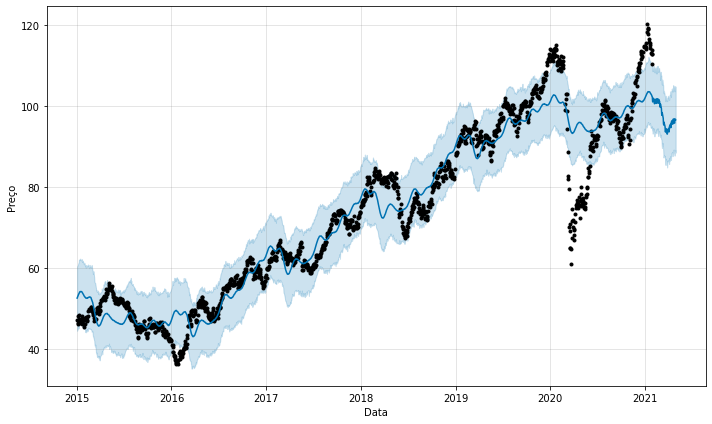

In [81]:
modelo.plot(previsoes, xlabel='Data', ylabel='Preço');

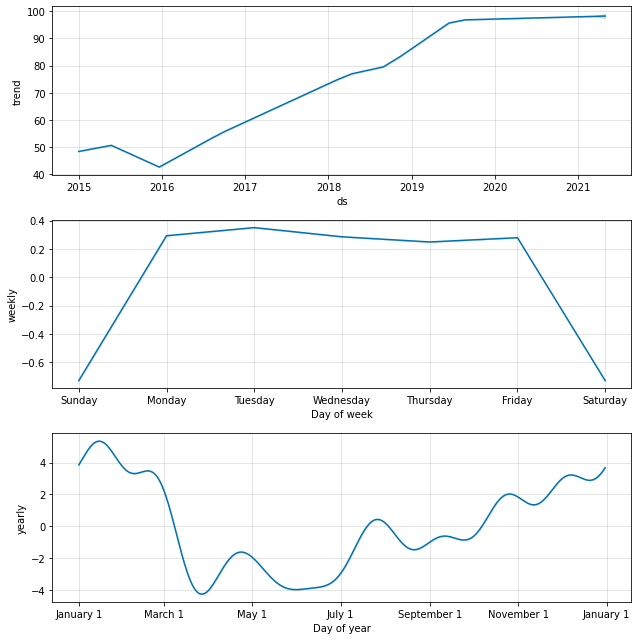

In [82]:
modelo.plot_components(previsoes);

In [85]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(modelo, previsoes)

In [84]:
plot_components_plotly(modelo, previsoes)

## Avaliação

In [86]:
teste.shape

(422,)

In [87]:
teste.tail()

Date
2021-01-22    113.180000
2021-01-26    112.970001
2021-01-27    112.970001
2021-01-28    113.910004
2021-01-29    110.559998
Name: BOVA, dtype: float64

In [95]:
pred = modelo.make_future_dataframe(periods=0)  # ateh dia atual
previsoes = modelo.predict(pred)

In [96]:
previsoes.shape

(1503, 19)

In [97]:
previsoes.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1498,2021-01-22,98.003034,94.662093,110.851325,98.003034,98.003034,5.198046,5.198046,5.198046,0.279474,0.279474,0.279474,4.918572,4.918572,4.918572,0.0,0.0,0.0,103.201081
1499,2021-01-26,98.012100,95.293688,110.405948,98.012100,98.012100,4.757074,4.757074,4.757074,0.350727,0.350727,0.350727,4.406348,4.406348,4.406348,0.0,0.0,0.0,102.769174
1500,2021-01-27,98.014366,95.171389,110.517401,98.014366,98.014366,4.556567,4.556567,4.556567,0.285885,0.285885,0.285885,4.270683,4.270683,4.270683,0.0,0.0,0.0,102.570933
1501,2021-01-28,98.016632,95.082188,110.287581,98.016632,98.016632,4.386296,4.386296,4.386296,0.249247,0.249247,0.249247,4.137048,4.137048,4.137048,0.0,0.0,0.0,102.402928
1502,2021-01-29,98.018899,94.097979,110.339975,98.018899,98.018899,4.287321,4.287321,4.287321,0.279474,0.279474,0.279474,4.007847,4.007847,4.007847,0.0,0.0,0.0,102.306220


In [98]:
previsoes = previsoes['yhat'].tail(len(teste))

In [99]:
previsoes

1081     91.017270
1082     91.036376
1083     90.937078
1084     90.870444
1085     90.875644
           ...    
1498    103.201081
1499    102.769174
1500    102.570933
1501    102.402928
1502    102.306220
Name: yhat, Length: 422, dtype: float64

In [100]:
mean_absolute_error(teste, previsoes)

6.807378656260871

## Exercício

In [102]:
dataset = pd.read_csv('acoes_ex.csv', usecols = ['Date', 'AMBEV'])
dataset = dataset[['Date', 'AMBEV']].rename(columns = {'Date': 'ds', 'AMBEV': 'y'})
dataset

,ds,y
0,2015-01-02,16.020000
1,2015-01-05,15.730000
2,2015-01-06,16.330000
3,2015-01-07,16.559999
4,2015-01-08,16.540001
...,...,...
1498,2021-01-22,15.030000
1499,2021-01-26,15.400000
1500,2021-01-27,15.400000
1501,2021-01-28,15.540000


In [104]:
%%time
from fbprophet import Prophet
model = Prophet()
model.fit(dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 851 ms, sys: 62.9 ms, total: 914 ms
Wall time: 942 ms


In [105]:
teste = dataset[1081:]
teste.shape

(422, 2)

In [106]:
pred = model.make_future_dataframe(periods=0)
previsoes = model.predict(pred)

In [107]:
previsoes = previsoes['yhat'].tail(len(teste))

In [108]:
previsoes

1081    17.394673
1082    17.386316
1083    17.324843
1084    17.293384
1085    17.282477
          ...    
1498    12.860293
1499    12.817533
1500    12.753828
1501    12.719601
1502    12.705397
Name: yhat, Length: 422, dtype: float64

In [109]:
teste['y']

1081    17.010000
1082    16.940001
1083    16.610001
1084    16.639999
1085    16.490000
          ...    
1498    15.030000
1499    15.400000
1500    15.400000
1501    15.540000
1502    15.110000
Name: y, Length: 422, dtype: float64

In [110]:
mean_absolute_error(teste['y'], previsoes)

1.4084284886507246